In [1]:
from context import *

## Set of available LED

In [2]:
mpeaks = [360, 380, 415, 470, 505, 530, 565, 617]
mnames = ['duv', 'uv', 'violet', 'blue', 'cyan', 'green', 'lime', 'orange']
np.random.seed(5)
intensity_bounds=(
    np.zeros(len(mpeaks)),  
    (np.random.random(len(mpeaks)) + np.arange(len(mpeaks))/len(mpeaks) + 0.5) * 10
)
measured_spectra = dreye.get_led_spectra_container(
    mpeaks, 
    names=mnames, 
    intensity_bounds=intensity_bounds, 
    output_bounds=(0, 5)
)

In [3]:
colors = sns.color_palette(
    'rainbow', 
    len(mpeaks)
)
mcmap = dict(zip(mnames, colors))

## Spectra of LEDs used for fitting

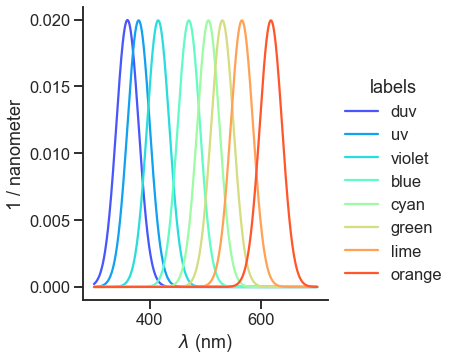

In [4]:
measured_spectra.normalized_spectra.plot(palette=mcmap)

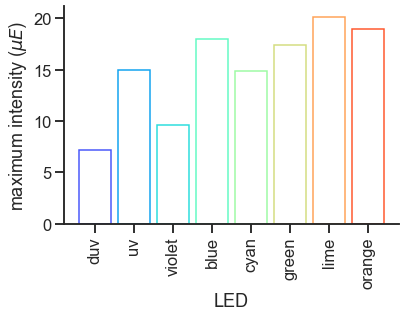

In [5]:
# intensity range of LEDs
plt.bar(
    np.arange(len(mpeaks)),
    measured_spectra.intensity_bounds[1], 
    color='white', edgecolor=mcmap.values()
)
plt.xticks(np.arange(len(mpeaks)), mcmap, rotation='vertical')
plt.xlabel('LED')
plt.ylabel(r'maximum intensity ($\mu E$)')
sns.despine()

In [6]:
m = 4

In [7]:
combos = np.array([
    [True, False, True, True, False, False, True, False], 
    [True, True, True, False, False, False, False, True], 
    [False, True, False, True, False, True, False, True], 
    [True, False, False, True, False, False, True, True], 
    [True, False, True, True, False, False, False, True], 
    [True, False, False, True, False, True, False, True],
    [True, False, True, False, True, False, False, True], 
    [False, True, True, False, True, False, False, True], 
    [True, False, False, False, True, False, True, True], 
    [False, True, False, True, False, False, True, True],
])
n_combos = len(combos)

In [8]:
n_combos

10

In [9]:
metrics1 = dreye.MeasuredSpectraMetrics(
    combos, 
    fish_log_model, measured_spectra
)
metrics2 = dreye.MeasuredSpectraMetrics(
    combos, 
    fly_log_model, measured_spectra
)

In [10]:
metrics1.compute_as_peaks()

Index(['duv', 'violet', 'blue', 'lime'], dtype='object')

In [11]:
metrics2.compute_as_peaks()

Index(['duv', 'uv', 'violet', 'orange'], dtype='object')

In [12]:
def pca(X):
    X = np.log(X+1)/np.log(2)
    cov = X.T @ X
    eigval, eigvec = np.linalg.eig(cov)
    argsort = np.argsort(eigval)[::-1]
    eigval = eigval[argsort]
    eigvec = eigvec[:, argsort]
    evar_ratio = eigval/np.sum(eigval)
    return eigvec

In [13]:
Bnames = ['achr', 'c1', 'c2', 'c3']

In [47]:
def get_df(metrics, name):
    df_mw = metrics.get_excitation_metrics(
        metric='volume',
        normalize=True, 
        B=np.eye(n), 
        B_name='prs'
    )
    df_gamut = metrics.compute_alt_gamuts(
        normalize=True, nonlin=lambda x: np.log(x+1)/np.log(2), 
        relative=False, rtol=0.9
    )
    df = pd.concat([df_mw, df_gamut])

    pcs = pca(metrics.photoreceptor_model.sensitivity.magnitude)
    for idx, bname in enumerate(Bnames):
        df_ = metrics.get_excitation_metrics(
            metric='mean_width', 
            normalize=True, 
            B=pcs[:, idx], 
            B_name=bname
        )
        df = df.append(df_, ignore_index=True)
        
    df['name'] = name
    df['mname'] = df.apply(
        lambda x: x['metric_name'] if x['transformation'] is None else x['transformation'], 
        axis=1
    )
    return df

In [48]:
df1 = get_df(metrics1, 'zebrafish')
df2 = get_df(metrics2, 'fruit fly')
df = pd.concat([df1, df2])

In [49]:
pdf = df.pivot(
    ['light_combos'], 
    ['name', 'mname'], 
    'metric'
)
pdf

name                   zebrafish                                          \
mname                        prs alt_gamut      achr        c1        c2   
light_combos                                                               
duv+blue+green+orange   0.722780  0.658717  0.755316  0.844360  0.721103   
duv+blue+lime+orange    0.798112  0.543208  0.877867  0.857518  0.727344   
duv+cyan+lime+orange    1.000000  0.260232  1.000000  1.000000  1.000000   
duv+uv+violet+orange    0.020539  0.134035  0.840443  0.365484  0.310565   
duv+violet+blue+lime    0.323018  0.569871  0.749639  0.544214  0.568499   
duv+violet+blue+orange  0.310850  0.746176  0.720844  0.502613  0.599445   
duv+violet+cyan+orange  0.445151  1.000000  0.840524  0.589081  0.519948   
uv+blue+green+orange    0.621479  0.565716  0.844948  0.866173  0.679628   
uv+blue+lime+orange     0.596938  0.450735  0.897421  0.867928  0.688763   
uv+violet+cyan+orange   0.320153  0.700934  0.758033  0.605244  0.544871   

name                             fruit fly                                \
mname                         c3       prs alt_gamut      achr        c1   
light_combos                                                               
duv+blue+green+orange   0.759964  0.878913  0.989476  0.879551  0.999560   
duv+blue+lime+orange    0.747732  0.924467  1.000000  0.809732  1.000000   
duv+cyan+lime+orange    1.000000  1.000000  0.840729  0.844231  0.980754   
duv+uv+violet+orange    0.321861  0.044443  0.146319  0.810361  0.625453   
duv+violet+blue+lime    0.461931  0.304026  0.459262  0.759245  0.770755   
duv+violet+blue+orange  0.460078  0.311520  0.532332  0.993382  0.744338   
duv+violet+cyan+orange  0.428283  0.399101  0.532490  0.848522  0.790866   
uv+blue+green+orange    0.662248  0.544665  0.623415  0.899333  0.890182   
uv+blue+lime+orange     0.727751  0.720704  0.767743  0.981447  0.949222   
uv+violet+cyan+orange   0.404753  0.301223  0.320977  1.000000  0.856776   

name                                        
mname                         c2        c3  
light_combos                                
duv+blue+green+orange   0.869341  0.807156  
duv+blue+lime+orange    0.903962  0.830010  
duv+cyan+lime+orange    1.000000  1.000000  
duv+uv+violet+orange    0.465647  0.195765  
duv+violet+blue+lime    0.733970  0.521919  
duv+violet+blue+orange  0.790761  0.417897  
duv+violet+cyan+orange  0.766007  0.598595  
uv+blue+green+orange    0.765909  0.744754  
uv+blue+lime+orange     0.728923  0.831979  
uv+violet+cyan+orange   0.768882  0.646394

In [50]:
pdf['zebrafish'].sum(axis=1).idxmax()

'duv+cyan+lime+orange'

In [51]:
pdf['fruit fly'].sum(axis=1).idxmax()

'duv+cyan+lime+orange'

Text(29.33387500000005, 0.5, 'LED combination')

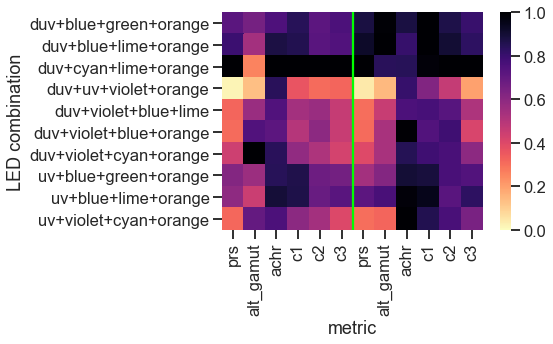

In [52]:
sns.heatmap(
    pdf, 
    vmin=0, vmax=1, 
    cmap='magma_r', 
    xticklabels=pdf.columns.get_level_values(-1), 
    square=True
)
plt.axvline(len(pdf.columns)//2, color='lime')
plt.xlabel('metric')
plt.ylabel('LED combination')

In [20]:
from dreye.estimators import metrics

In [21]:
sense = dreye.Sensitivity(
    [365, 460, 515],
    domain=wls, 
    from_template=True, 
    name='test', 
    labels=['short', 'medium', 'long']
)
pr_model = dreye.LinearPhotoreceptor(sense)

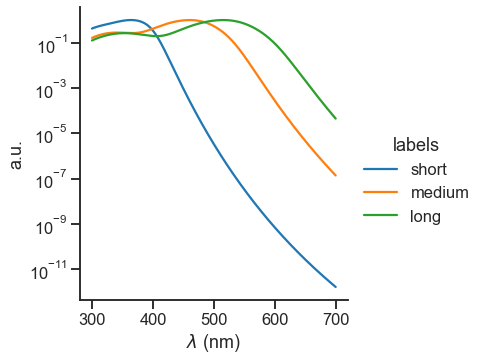

In [22]:
sense.plot()
plt.yscale('log')

In [58]:
rtol = 0.9

In [23]:
wls_tuple, ratios = pr_model.compute_ratios(return_wls=True, rtol=rtol)

In [24]:
wls_tuple

(348.0, 533.0)

In [25]:
X = metrics.probs_vec_to_cart(ratios)

In [26]:
simplex = metrics.probs_vec_to_cart(np.vstack([np.eye(3), np.eye(3)[0]]))

In [27]:
X.shape

(185, 2)

In [28]:
from mpl_toolkits import mplot3d

In [29]:
bwls = np.linspace(*wls_tuple, X.shape[0])

In [30]:
metrics_ = dreye.MeasuredSpectraMetrics(
    3, 
    pr_model, measured_spectra
)

In [62]:
func = lambda x: np.maximum(np.log(x) + 4, 0)

In [63]:
mdf = metrics_.compute_alt_gamuts(
    rtol=rtol, 
    nonlin=func
)

In [64]:
mdf.set_index('light_combos').sort_values('metric', ascending=False)['metric'].head()

light_combos
duv+cyan+orange     0.260974
duv+lime+orange     0.202014
duv+blue+orange     0.189831
uv+lime+orange      0.160395
duv+green+orange    0.158206
Name: metric, dtype: float64

In [65]:
points = metrics_.get_captures('duv+blue+orange')
points = func(points)
points = points / np.sum(np.abs(points), axis=-1, keepdims=True)
points = metrics.probs_vec_to_cart(points)

points2 = metrics_.get_captures('duv+violet+orange')
points2 = func(points2)
points2 = points2 / np.sum(np.abs(points2), axis=-1, keepdims=True)
points2 = metrics.probs_vec_to_cart(points2)

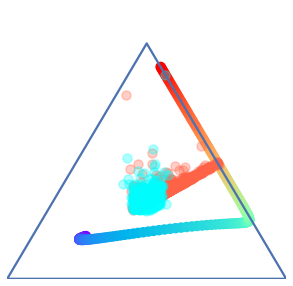

In [66]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*X.T, c=bwls, cmap='rainbow')
ax.plot(*simplex.T)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)
ax.scatter(*points.T, color='tomato', alpha=0.3)
ax.scatter(*points2.T, color='cyan', alpha=0.3)

In [68]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

In [87]:
def plot_hull(hull, color='blue'):
    """
    plot relative to `in_hull` for 2d data
    """
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    # plot triangulation
    poly = PolyCollection(hull.points[hull.vertices], facecolors='w', edgecolors='b')
    plt.title('in hull')
    #plt.gca().add_collection(poly)
    plt.plot(hull.points[:, 0], hull.points[:, 1], 'o', color=color)

    # plot the convex hull
    edges = set()
    edge_points = []

    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add((i, j))
        edge_points.append(hull.points[[i, j]])

    for ia, ib in hull.convex_hull:
        add_edge(ia, ib)

    lines = LineCollection(edge_points, color=color)
    plt.gca().add_collection(lines)

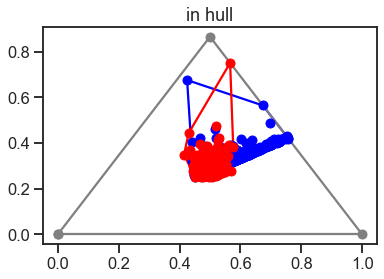

In [88]:
plot_hull(points, color='blue')
plot_hull(simplex, color='gray')
plot_hull(points2, color='red')